<h1>Working with Missing and Duplicate Data</h1>

Handle missing data without having to drop rows and columns using data on motor vehicle collisions released by New York City and published on the NYC OpenData website. There is data on over 1.5 million collisions dating back to 2012, with additional data continuously added

In [44]:
import pandas as pd
import seaborn as sns

mvc = pd.read_csv('nypd_mvc_2018.csv')
# sum null values
null_counts = mvc.isnull().sum()
null_counts

unique_key                 0
date                       0
time                       0
borough                20646
location                3885
on_street              13961
cross_street           29249
off_street             44093
pedestrians_injured        0
cyclist_injured            0
motorist_injured           0
total_injured              1
pedestrians_killed         0
cyclist_killed             0
motorist_killed            0
total_killed               5
vehicle_1                355
vehicle_2              12262
vehicle_3              54352
vehicle_4              57158
vehicle_5              57681
cause_vehicle_1          175
cause_vehicle_2         8692
cause_vehicle_3        54134
cause_vehicle_4        57111
cause_vehicle_5        57671
dtype: int64

<h2>Calculate percentage of null values</h2>

Let's calculate the percentage of null values in each column. Below, we divide the number of null values in each column by the total number of values in the data set

In [45]:
null_counts_pct = null_counts / mvc.shape[0] *100
null_df=pd.DataFrame({'null_counts':null_counts,'null_pct':null_counts_pct})
null_df = null_df.T.astype(int)
null_df

,unique_key,date,time,borough,location,on_street,cross_street,off_street,pedestrians_injured,cyclist_injured,...,vehicle_1,vehicle_2,vehicle_3,vehicle_4,vehicle_5,cause_vehicle_1,cause_vehicle_2,cause_vehicle_3,cause_vehicle_4,cause_vehicle_5
null_counts,0,0,0,20646,3885,13961,29249,44093,0,0,...,355,12262,54352,57158,57681,175,8692,54134,57111,57671
null_pct,0,0,0,35,6,24,50,76,0,0,...,0,21,93,98,99,0,15,93,98,99


<h1>Imputation</h1>

Let's analyze and handl null values in 'killed' related columns.

Noticed the relationships between the columns: total_killed = sum(pedestrians_killed, cyclist_killed, motorist_killed)

We might be able to "fill in" the missing values with the sums of the individual columns for that row. 

The technical name for filling in a missing value with a replacement value is called **imputation**.


<h2>Handle 'Killed' and 'Injured' missing values</h2>

Statistica of the missing values from 'killed' and 'injured' data. Then using the **imputation** to fill the missing data.


In [46]:
# all killed related columns
killed_cols = [col for col in mvc.columns if 'killed' in col]
killed = mvc[killed_cols].copy()

In [47]:
# manually calcus the sum of columns : pedestrians_killed, cyclist_killed, motorist_killed
killed_manual_sum = killed.iloc[:,0:3].sum(axis=1)

# statistics the total_killed != killed_manual_sum
killed_mask = killed_manual_sum != killed['total_killed']
killed_no_equ = killed[killed_mask]

killed_no_equ

,pedestrians_killed,cyclist_killed,motorist_killed,total_killed
3508,0,0,0,NaN
20163,0,0,0,NaN
22046,0,0,1,0.0
48719,0,0,0,NaN
55148,0,0,0,NaN
55699,0,0,0,NaN



Using the funtion **Series.mask()** function to fill the missing or wrong values.


In [48]:
import numpy as np

# fill na values first
killed['total_killed'] = killed['total_killed'].mask(killed['total_killed'].isnull(),killed_manual_sum)

# then fill the wrong values with nan
killed['total_killed'] = killed['total_killed'].mask(killed['total_killed'] != killed_manual_sum, np.nan)


Using the same method to fill the missing values in jnjured related columns


In [49]:
injured_cols=[col for col in mvc.columns if 'injured' in col]
injured = mvc[injured_cols].copy()
injured_manual_sum = injured.iloc[:,0:3].sum(axis=1)

# fill missing/worng values
injured['total_injured'] = injured['total_injured'].mask(injured['total_injured'].isnull(), injured_manual_sum)
injured['total_injured'] = injured['total_injured'].mask(injured['total_injured']!=injured_manual_sum, np.nan)

In [54]:
summary = {'injured':[mvc['total_injured'].isnull().sum(), injured['total_injured'].isnull().sum()],
                        'killed':[mvc['total_killed'].isnull().sum(), killed['total_killed'].isnull().sum()]}

pd.DataFrame(summary, index=['before','after'])

,injured,killed
before,1,5
after,21,1



Sometimes, the number of null values may increase, but we've actually done is fill the null values and identify the values have suspect data. This will make any analysis we do on this data more accurate in the long run.

Now, put the revised data into the original dataset


In [55]:
mvc['total_injured'] = injured['total_injured']
mvc['total_killed'] = killed['total_killed']

<h2> Heatmap</h2>

Except calculate the number of null values, we can aslo use the **heatmap** to display the null values in the whole dataset.



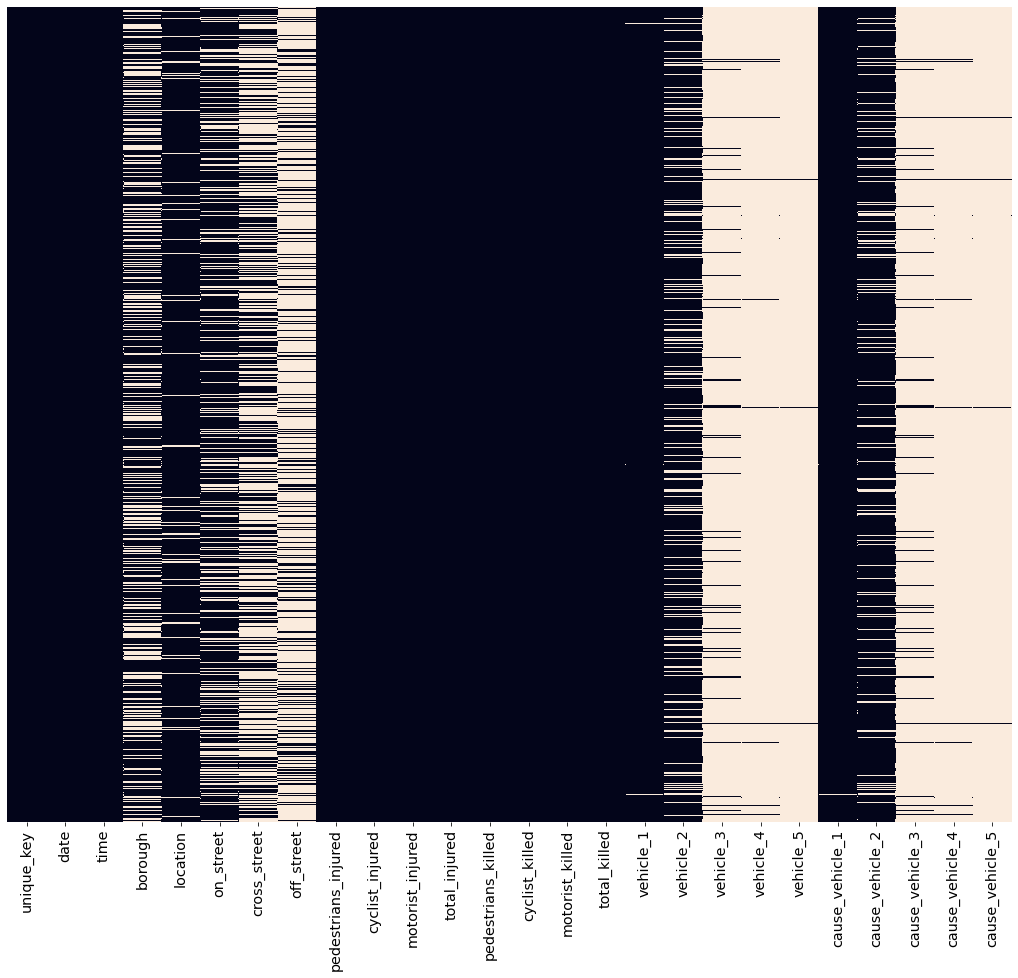

In [61]:
import matplotlib.pyplot as plt

def plot_null_matrix(df, figsize=(18,15)):
    plt.figure(figsize=figsize)
    df_null = df.isnull()
    
    sns.heatmap(df_null, cbar=False, yticklabels=False)
    plt.xticks(rotation=90, size='x-large')
    plt.show()

plot_null_matrix(mvc)

In [71]:
def plot_null_correlations(df):
    
    cols_with_missing_values = df.columns[df.isnull().sum() > 0]
    missing_corr = df[cols_with_missing_values].isnull().corr()
    
    missing_corr = missing_corr.iloc[1:,:-1]
    #Cells with missing values are automatically masked
    mask = np.triu(np.ones_like(missing_corr), k=1)
    
    plt.figure(figsize=(20,14))
    ax = sns.heatmap(missing_corr, vmin=-1, vmax=1, cmap='RdBu', cbar=False, mask=mask, annot=True)


    for text in ax.texts:
        t = float(text.get_text())
        if -0.05 < t <0.01:
            text.set_text('')
        else: 
            text.set_text(round(t, 2))
    plt.xticks(rotation=90, size='x-large')
    plt.yticks(rotation=0, size='x-large')
    
    plt.show()


Let's analyze the relationship between all columns with missing values

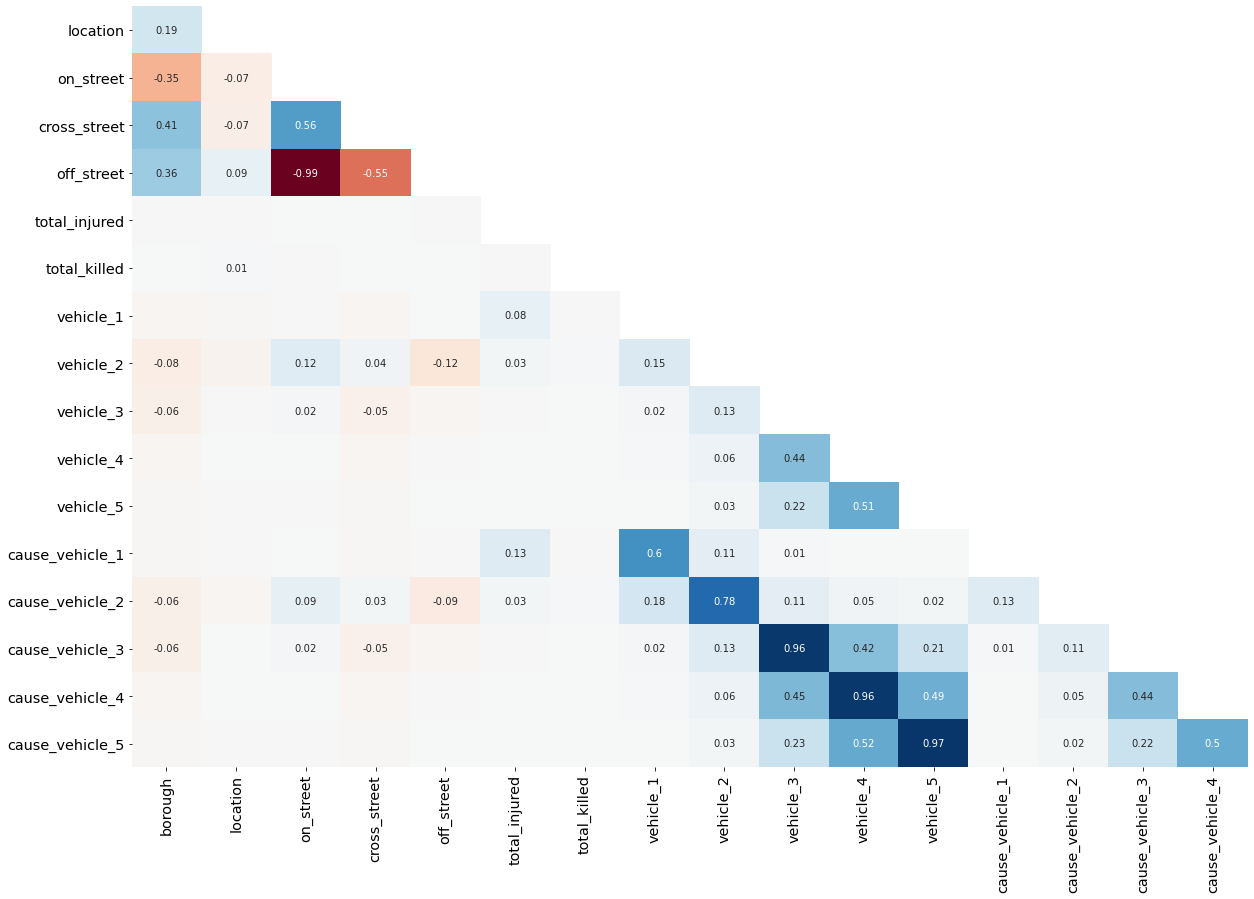

In [72]:
plot_null_correlations(mvc)


<h2>Handle 'vehicle' data</h2>

- Using the correlation map to display the relationships among vehicle related columns

- Fill the mnissing data from 'vehicle' columns by **imputation** method.


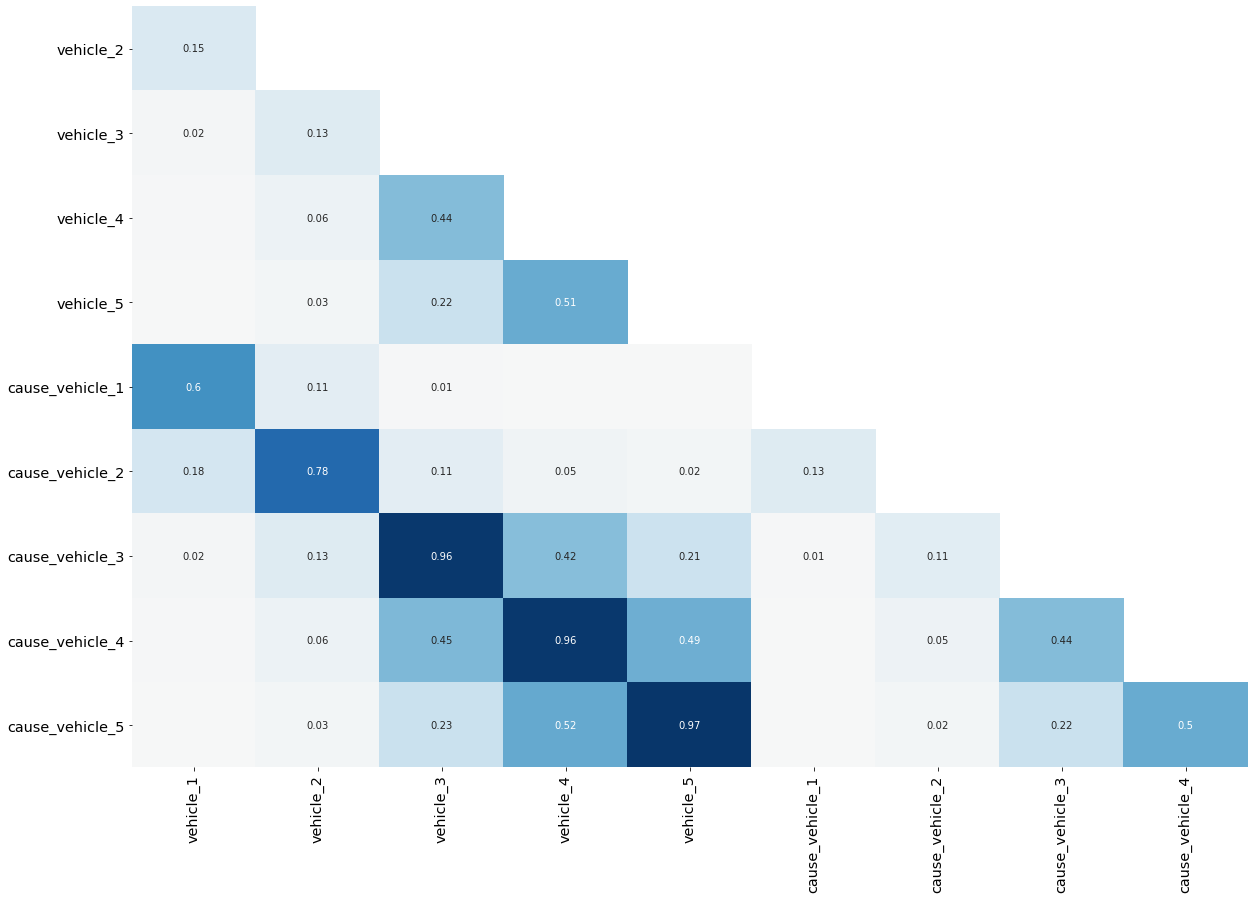

In [73]:
veh_cols = [col for col in mvc.columns if 'vehicle' in col]
vehicle = mvc[veh_cols]
plot_null_correlations(vehicle)

In [74]:
def summarize_missing():
    v_missing_data = []

    for v in range(1,6):
        v_col = 'vehicle_{}'.format(v)
        c_col = 'cause_vehicle_{}'.format(v)

        v_missing = (mvc[v_col].isnull() & mvc[c_col].notnull()).sum()
        c_missing = (mvc[c_col].isnull() & mvc[v_col].notnull()).sum()

        v_missing_data.append([v, v_missing, c_missing])

    col_labels = columns=["vehicle_number", "vehicle_missing", "cause_missing"]
    return pd.DataFrame(v_missing_data, columns=col_labels)

summary_before = summarize_missing()

In [75]:
for v in range(1,6):
    v_col = 'vehicle_{}'.format(v)
    c_col = 'cause_vehicle_{}'.format(v)
    
    v_missing_mask = mvc[v_col].isnull() & mvc[c_col].notnull()
    c_missing_mask = mvc[c_col].isnull() & mvc[v_col].notnull()
    
    mvc[v_col] = mvc[v_col].mask(v_missing_mask, 'Unspecified')
    mvc[c_col] = mvc[c_col].mask(c_missing_mask, 'Unspecified')
    
summary_after=summarize_missing()
    


<h2>Handle location data</h2>
<p></p>
<p></p>

In [77]:
loc_cols = ['borough', 'location', 'on_street', 'off_street', 'cross_street']
location_data = mvc[loc_cols]
location_data.head()

,borough,location,on_street,off_street,cross_street
0,MANHATTAN,"(40.742832, -74.00771)",WEST 15 STREET,NaN,10 AVENUE
1,BROOKLYN,"(40.623714, -73.99314)",16 AVENUE,NaN,62 STREET
2,NaN,"(40.591755, -73.9083)",BELT PARKWAY,NaN,NaN
3,QUEENS,"(40.73602, -73.87954)",GRAND AVENUE,NaN,VANLOON STREET
4,BRONX,"(40.884727, -73.89945)",NaN,208 WEST 238 STREET,NaN


In [78]:
location_data.isnull().sum()

borough         20646
location         3885
on_street       13961
off_street      44093
cross_street    29249
dtype: int64


Using correlationships map to find the relationships among these columns of data.



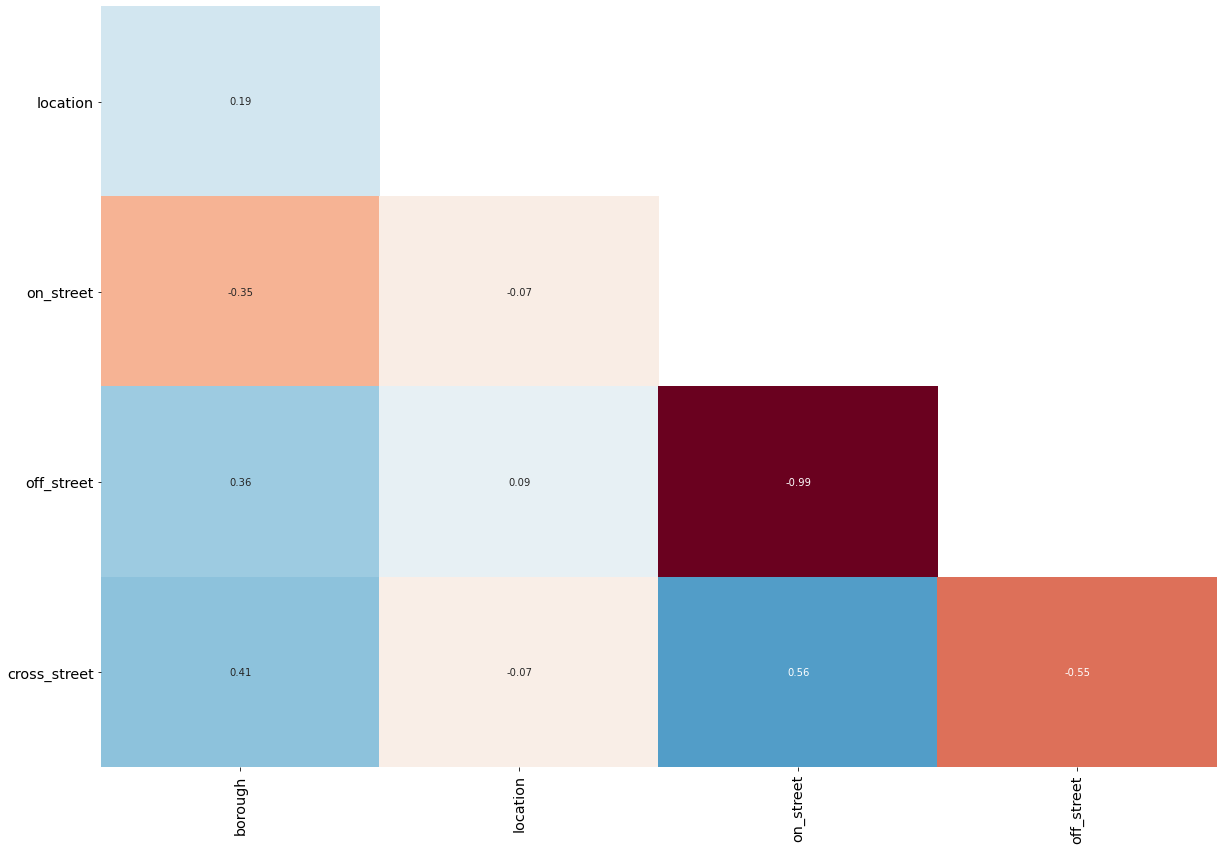

In [79]:
plot_null_correlations(location_data)

<p></p>
None of these columns have strong correlations except for off_street and on_street which have a near perfect negative correlation. That means for almost every row that has a null value in one column, the other has a non-null value and vice-versa.
<p></p>


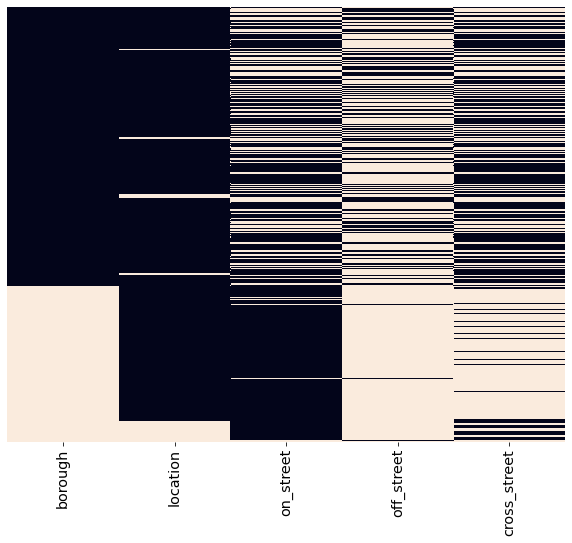

In [83]:

plot_null_matrix(location_data.sort_values(loc_cols), figsize=(10,8))

**Conclusions**
 
- About two-thirds rows have missing values for Borough, and most rows have a non-null value for either on_street or off_street, and some also have a value for cross_street
- Since the five columns are all about locations data, we can use the no-null values combining with the geolocation APIs to fill some of the null values.